# Section A: Convolutinal Nueral Network

Name: Joen Choo Tze En<br>
Admin Number: P2415828<br>
Class: DAAA/FT/2B/22<br>

## Project Objective
Implement an image classifier using a deep learning network, to classify images into 11 classes of vegetables.<br/>
We will build two models for two different input sizes (23x23 and 101x101)<br/>
We want to compare the two classification models and their results

---

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import random
import cv2
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
randomseed = 17

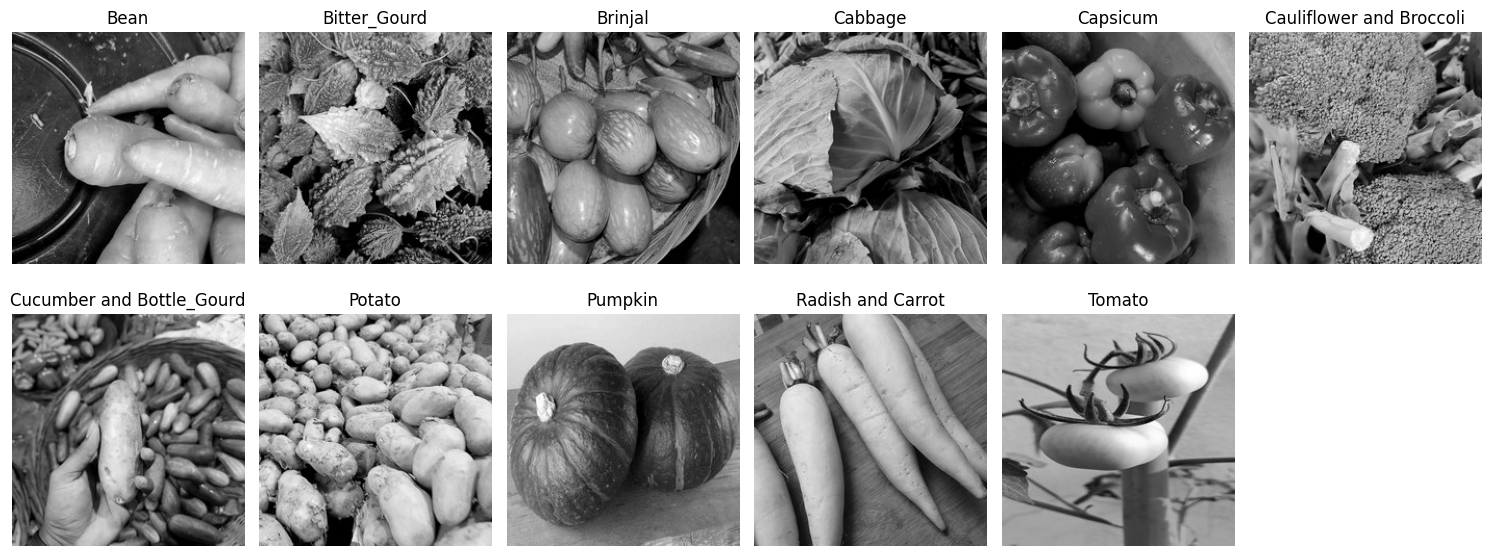

In [9]:
def show_images(folder_path):
    class_names = sorted(os.listdir(folder_path))
    plt.figure(figsize=(15, 6))
    for i, cls in enumerate(class_names):
        class_dir = os.path.join(folder_path, cls)
        img_name = os.listdir(class_dir)[random.randint(0,9)]
        img = cv2.imread(os.path.join(class_dir, img_name), cv2.IMREAD_GRAYSCALE)
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images('Datasets/train')

# | Preprocess Data

In [15]:
import os

# Paths to dataset folders
base_path = 'Datasets'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

image_size_small = (23, 23)
image_size_large = (101, 101)

train_data_23 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
val_data_23 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
test_data_23 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')

train_data_101 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
val_data_101 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
test_data_101 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [19]:
for (X_train_23, y_train_23), (X_test_23, y_test_23), (X_val_23, y_val_23) in zip(train_data_23, test_data_23, val_data_23):
    X_train_23 = X_train_23
    y_train_23 = y_train_23
    X_test_23 = X_test_23
    y_test_23 = y_test_23
    X_val_23 = X_val_23
    y_val_23 = y_val_23

In [18]:
for (X_train_101, y_train_101), (X_test_101, y_test_101), (X_val_101, y_val_101) in zip(train_data_101, test_data_101, val_data_101):
    X_train_101 = X_train_101
    y_train_101 = y_train_101
    X_test_101 = X_test_101
    y_test_101 = y_test_101
    X_val_101 = X_val_101
    y_val_101 = y_val_101

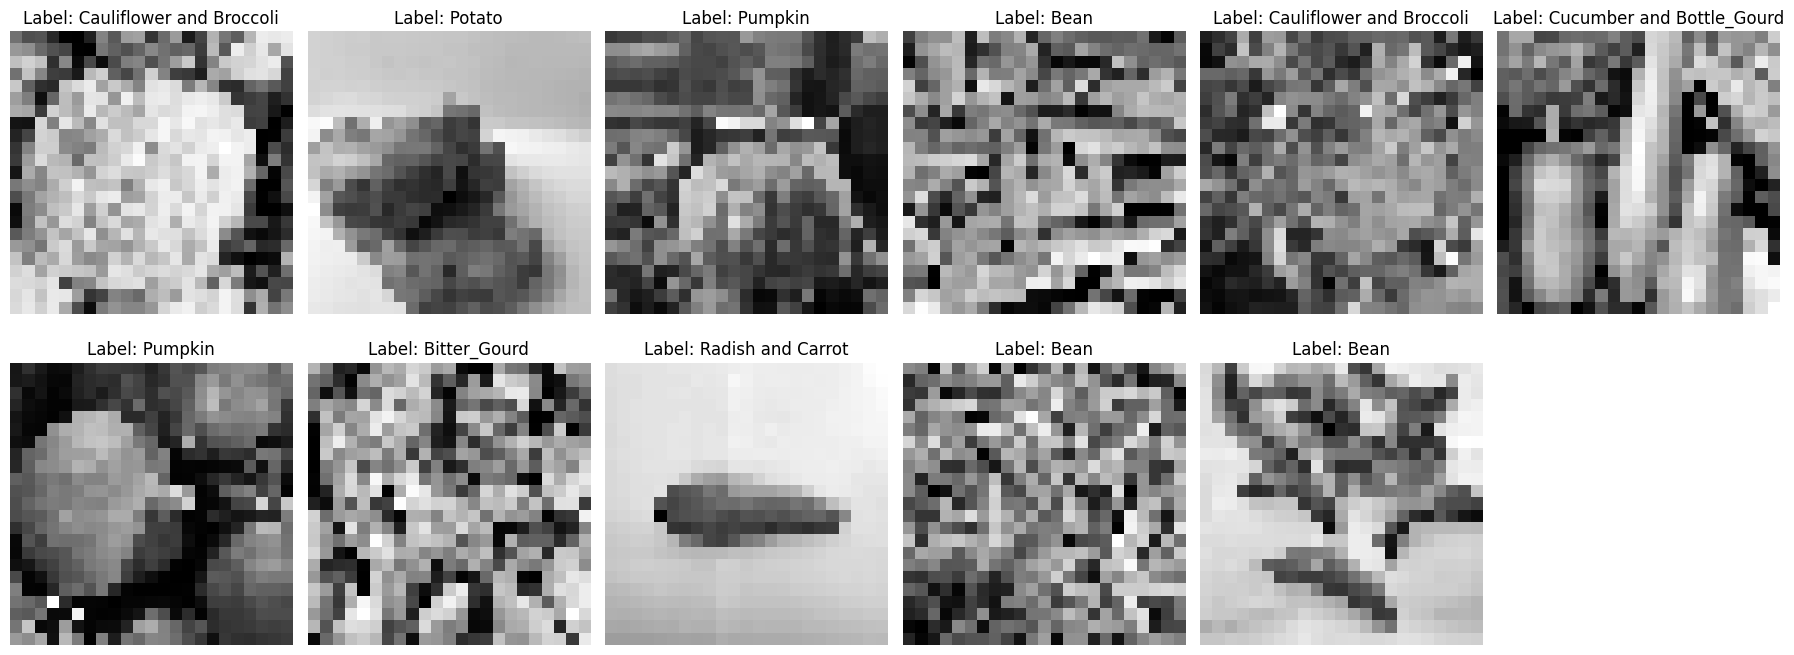

In [32]:
def show_sample_images(X, y, class_names):
    plt.figure(figsize=(18, 7))
    indices = random.sample(range(len(X)), len(class_names))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(X[idx], cmap='gray')
        plt.title(f"Label: {class_names[y[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = sorted(os.listdir(train_path))
show_sample_images(X_train_23, y_train_23, class_names)

[14, 6, 18, 9, 24, 19, 12, 25, 17, 4, 20]


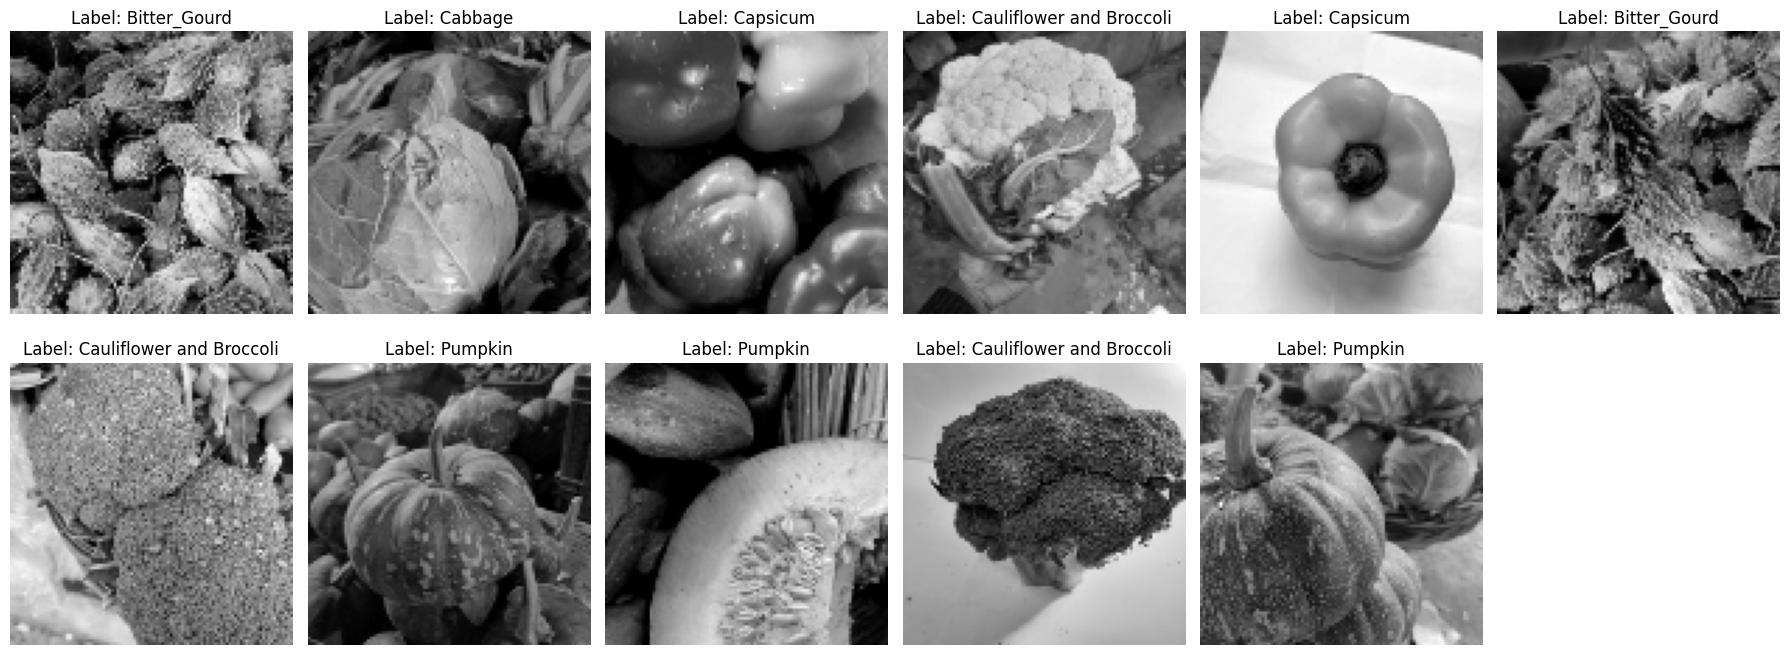

In [30]:
show_sample_images(X_train_101, y_train_101, class_names)

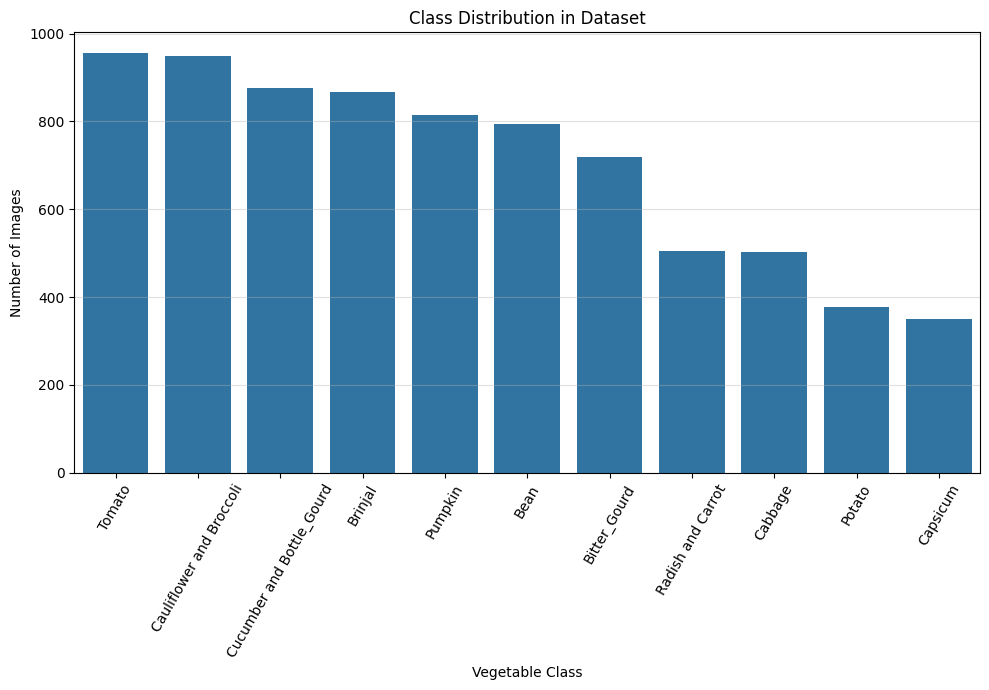

In [ ]:
label_names = [class_names[idx] for idx in y_train_23]

# Create a DataFrame
df = pd.DataFrame({'Class': label_names})

# Count and plot
plt.figure(figsize=(10, 7))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel("Vegetable Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

# | Model Training

In [33]:
from tensorflow.keras.utils import to_categorical

num_classes = len(class_names)
y_train_23_cat = to_categorical(y_train_23, num_classes)
y_val_23_cat = to_categorical(y_val_23, num_classes)
y_test_23_cat = to_categorical(y_test_23, num_classes)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(23, 23, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [35]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    X_train_23, y_train_23_cat,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_23, y_val_23_cat)
)

Epoch 1/15
1/1 [==============================] - 9s 9s/step - loss: 50.3621 - accuracy: 0.0312 - val_loss: 11.0551 - val_accuracy: 0.1667
Epoch 2/15
1/1 [==============================] - 0s 33ms/step - loss: 27.1868 - accuracy: 0.0625 - val_loss: 9.3998 - val_accuracy: 0.0833
Epoch 3/15
1/1 [==============================] - 0s 36ms/step - loss: 20.9627 - accuracy: 0.0312 - val_loss: 7.2331 - val_accuracy: 0.0833
Epoch 4/15
1/1 [==============================] - 0s 39ms/step - loss: 9.4514 - accuracy: 0.1562 - val_loss: 6.4176 - val_accuracy: 0.2500
Epoch 5/15
1/1 [==============================] - 0s 34ms/step - loss: 6.8840 - accuracy: 0.1562 - val_loss: 4.5747 - val_accuracy: 0.1667
Epoch 6/15
1/1 [==============================] - 0s 34ms/step - loss: 4.8655 - accuracy: 0.2188 - val_loss: 3.3176 - val_accuracy: 0.1250
Epoch 7/15
1/1 [==============================] - 0s 34ms/step - loss: 4.3906 - accuracy: 0.1562 - val_loss: 2.7518 - val_accuracy: 0.0833
Epoch 8/15
1/1 [=========

In [37]:
test_loss, test_acc = model.evaluate(X_test_23, y_test_23_cat)
print(f"Test accuracy: {test_acc:.2f}")

1/1 [==============================] - 0s 19ms/step - loss: 2.5355 - accuracy: 0.0833
Test accuracy: 0.08


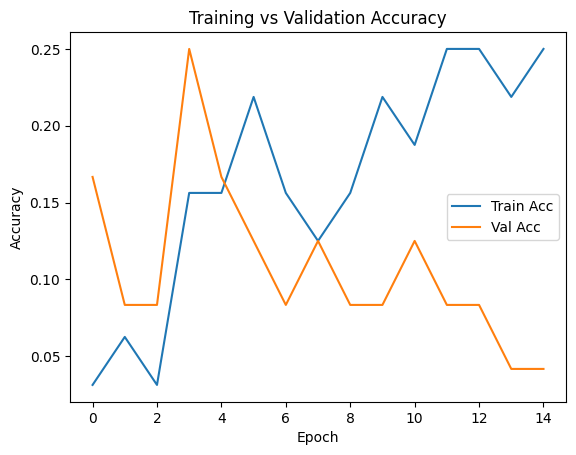

In [38]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()